# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Imports

In [1]:
import pickle
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import cv2
import skimage
import random
import imutils
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import os
%matplotlib inline


---
## Step 0: Load The Data

In [2]:
training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Sign names for each label

In [4]:
label_names = {}
with open('signnames.csv', 'r') as f_in:
    csv_reader = csv.DictReader(f_in)
    for row in csv_reader:
        label_names[int(row['ClassId'])] = row['SignName']
        
print('Labels/Sign names:')
label_names

Labels/Sign names:


{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [5]:
def summarize_labels(labels):
    '''Returns an array with the count for each label in a given array of labels'''
    summarized_labels = np.zeros(max(labels)+1, dtype=np.int32)
    for y in set(labels):
        summarized_labels[y] = sum(labels==y)
    return summarized_labels

summarized_train = summarize_labels(y_train)
summarized_valid = summarize_labels(y_valid)
summarized_test = summarize_labels(y_test)

### Number of examples of each sign for each dataset

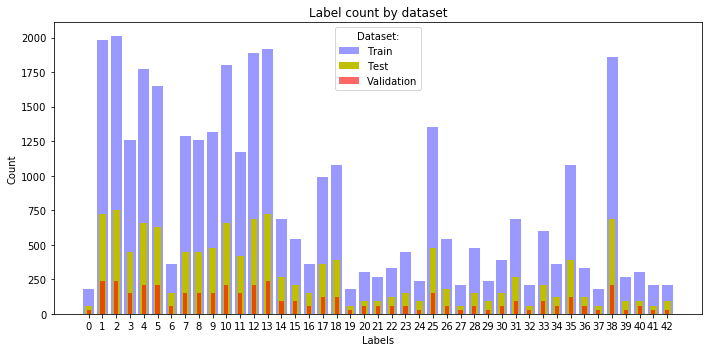

In [6]:
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 5))

index = range(len(summarized_train))
rects1 = plt.bar(index, summarized_train, 0.8,
                 alpha=0.4,
                 color='b',
                 label='Train')
rects2 = plt.bar(index, summarized_test, 0.5,
                 #alpha=opacity,
                 color='y',
                 label='Test')
rects3 = plt.bar(index, summarized_valid,0.3,
                 alpha=0.6,
                 color='r',
                 label='Validation')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label count by dataset')
plt.xticks(index)
plt.legend(title='Dataset:')
plt.tight_layout()
plt.savefig('report_images/summary_plot.png')
plt.show()


In [7]:
def show_images(images, titles = None, path = None): 
    '''Plots a series of images, using 4 columns when there are title for each image,
    and 10 columns when there is no title'''
    cols = 4 if titles else 10
    rows = (len(images) - 1)//cols + 1
    plt.figure(figsize=(14, 2*rows))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if titles:
            plt.title(titles[i])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    if path:
        plt.savefig(path, format='png')
    plt.show()

    

### Sample of each sign

Randomly selected sample of each sign type on the training set.

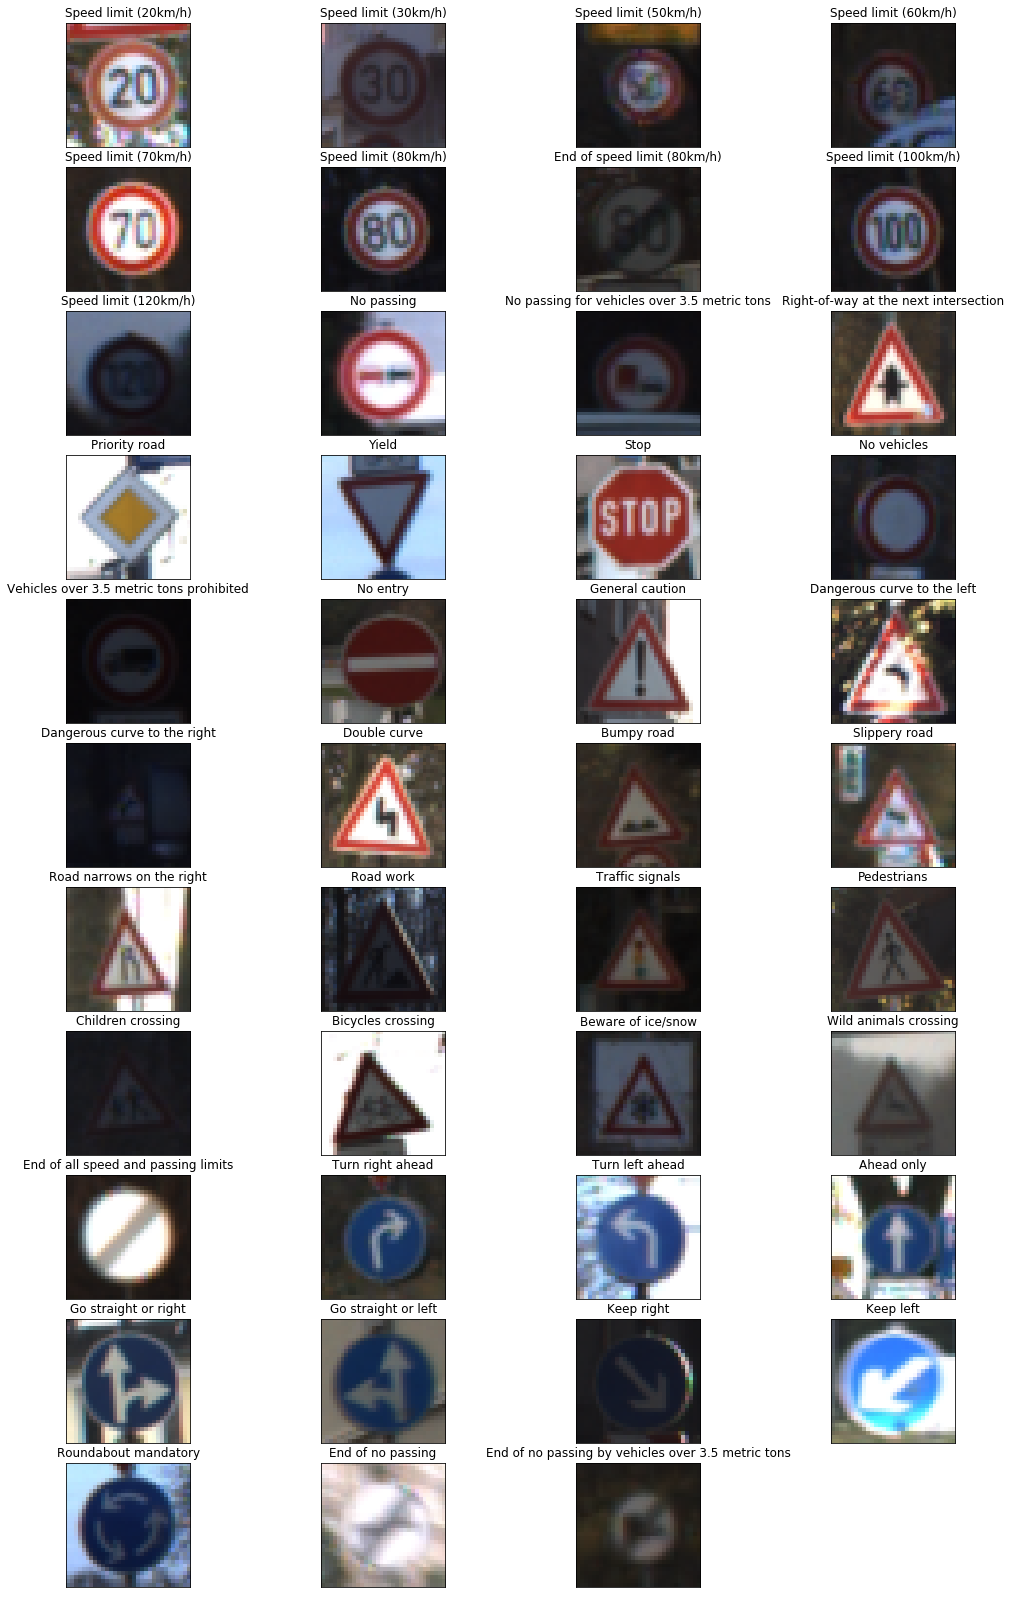

In [8]:
samples = []
labels = range(n_classes)
for y in set(labels):
    X = X_train[y_train==y]
    i = random.randint(0, len(X)-1)
    samples.append(X[i])
    
show_images(samples, label_names, 'report_images/samples.png')


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

---
As suggested by Yann Lecun in [this paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), I filled the training set with randomly tranformed samples of the original images. I have done many trials arbitrarily tweaking each of the transformation parameters, getting the best results with rotation between -20 and 20 degrees, translation between -3 and 3 pixels and scaling to between 27 and 36 pixels. 

Although I kept the random_noise function here, I am not using it. After the trials, with all kinds of noise type (e.g. gaussian, salt&pepper, ...) the accuracy was lower with the random noise than without it, probabily, because of the low resolution of the images, the other tranformations were already making enough noise on it.

I also tried transforming the sets to different colorspace. The results for each colorspace will be discussed later.

In [9]:
# Helper functions for randomly transform the dataset

def rotate_img(x):
    '''Rotates the image with a random angle between -20 and 20 degrees'''
    angle = random.randint(-20, 20)
    return imutils.rotate(x, angle)

def translate_img(x):
    '''Translates the image with a random value between -3 and 3 pixels on each axis'''
    x_shit = random.randint(-3, 3)
    y_shit = random.randint(-3, 3)
    return imutils.translate(x, x_shit, y_shit)

def scale_img(x):
    '''Scales the image with a random size between 27x27 and 36x36, and pads or crops it back to 32x32'''
    width = random.randint(26, 36)
    if width == 32:
        return x
    new_img = imutils.resize(x, width=width)
    diff = width - 32
    if diff > 0:
        diff1 = (diff+1)//2
        diff2 = diff//2
        return new_img[diff1:width-diff2,diff1:width-diff2]
    elif diff <  0:
        diff1 = -(diff+1)//2
        diff2 = -diff//2+1
        return np.pad(new_img, ((diff1,diff2),(diff1,diff2)), 'constant')

def brightness_adjust_img(x):
    '''Randomly adjusts the brightness of the image'''
    value = random.uniform(-0.3, 0.3)
    if value > 0:
        return np.where((x + value) > 1., 1., x + value)
    elif value < 0:
        return np.where((x + value) < -1., -1., x + value)
    else: 
        return x

def random_noise_img(x):
    '''Adds a gaussian noise to the image'''
    return skimage.util.random_noise(x, mode='gaussian')

def normalize_img(x):
    '''Normalizes the image'''
    return cv2.normalize(x.astype('float'), None, -1.0, 1.0, cv2.NORM_MINMAX)

def color_transform_normalize_img(x):
    '''Transforms the color space of the image, applies adaptative histogram equalization and normalize the image'''
    img = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
    #img = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
    img = clahe.apply(img)
    return normalize_img(img)

def transform_image(x):
    '''Randomly applies a combination of rotation, translation and scale to a given image'''
    img = np.copy(x)
    img = rotate_img(img)
    img = translate_img(img)
    img = scale_img(img)
    img = brightness_adjust_img(img)
    return img

def transform_dataset(x):
    '''Randomly applies a combination of rotation, translation and scale to each image in a given list'''
    return np.array([transform_image(img) for img in x])

def color_normalization(x):
    '''
    Transforms the color space of the image, applies adaptative histogram equalization and normalize 
    each image in a given list
    '''
    return np.array([color_transform_normalize_img(img) for img in x])

def normalize_dataset(x):
    '''Normalize each image in a given list'''
    return np.array([normalize_img(img) for img in x])

def random_noise(x):
    '''Adds a gaussian noise to each image in a given list'''
    return np.array([random_noise_img(img) for img in x])
    

---
In the cell below, I balance the training set multiplying the signs by a factor depending on its frequency on the original set, then take a fixed number of samples for each sign, in this case, 5000.


In [10]:
X_train = color_normalization(X_train)
X_valid = color_normalization(X_valid)
X_test = color_normalization(X_test)

# balance the training set with randomly tranformed samples of the original images 
multiplier = 3
ref = multiplier * max(summarized_train)
for i, n in enumerate(summarized_train):
    multiplier = ref//n
    if i:
        new_imgs = np.append(new_imgs, np.array(X_train[y_train==i].tolist()*multiplier), axis=0)
        new_labels = np.append(new_labels, y_train[y_train==i].tolist()*multiplier)
    else:
        new_imgs = np.array(X_train[y_train==i].tolist()*multiplier)
        new_labels = np.array(y_train[y_train==i].tolist()*multiplier)      
new_imgs, new_labels = shuffle(new_imgs, new_labels)
X_train = np.append(X_train, transform_dataset(new_imgs), axis=0)
y_train = np.append(y_train, new_labels, axis=0)

new_imgs = np.empty(None)
new_labels = np.empty(None, dtype = np.int)
n = 5000
for i in range(43):
    if i:
        new_imgs = np.append(new_imgs, (X_train[y_train==i])[:n], axis=0)
        new_labels = np.append(new_labels, (y_train[y_train==i])[:n])
    else:
        new_imgs = (X_train[y_train==i])[:n]
        new_labels = (y_train[y_train==i])[:n]
    
X_train = normalize_dataset(new_imgs)
y_train = new_labels

X_train = np.reshape((X_train), (len(X_train), 32, 32,1))
X_valid = np.reshape((X_valid), (len(X_valid), 32, 32,1))
X_test = np.reshape((X_test), (len(X_test), 32, 32,1))

print('Jittered training set size: ', len(X_train))
       

Jittered training set size:  215000


The samples above after the preprocessing

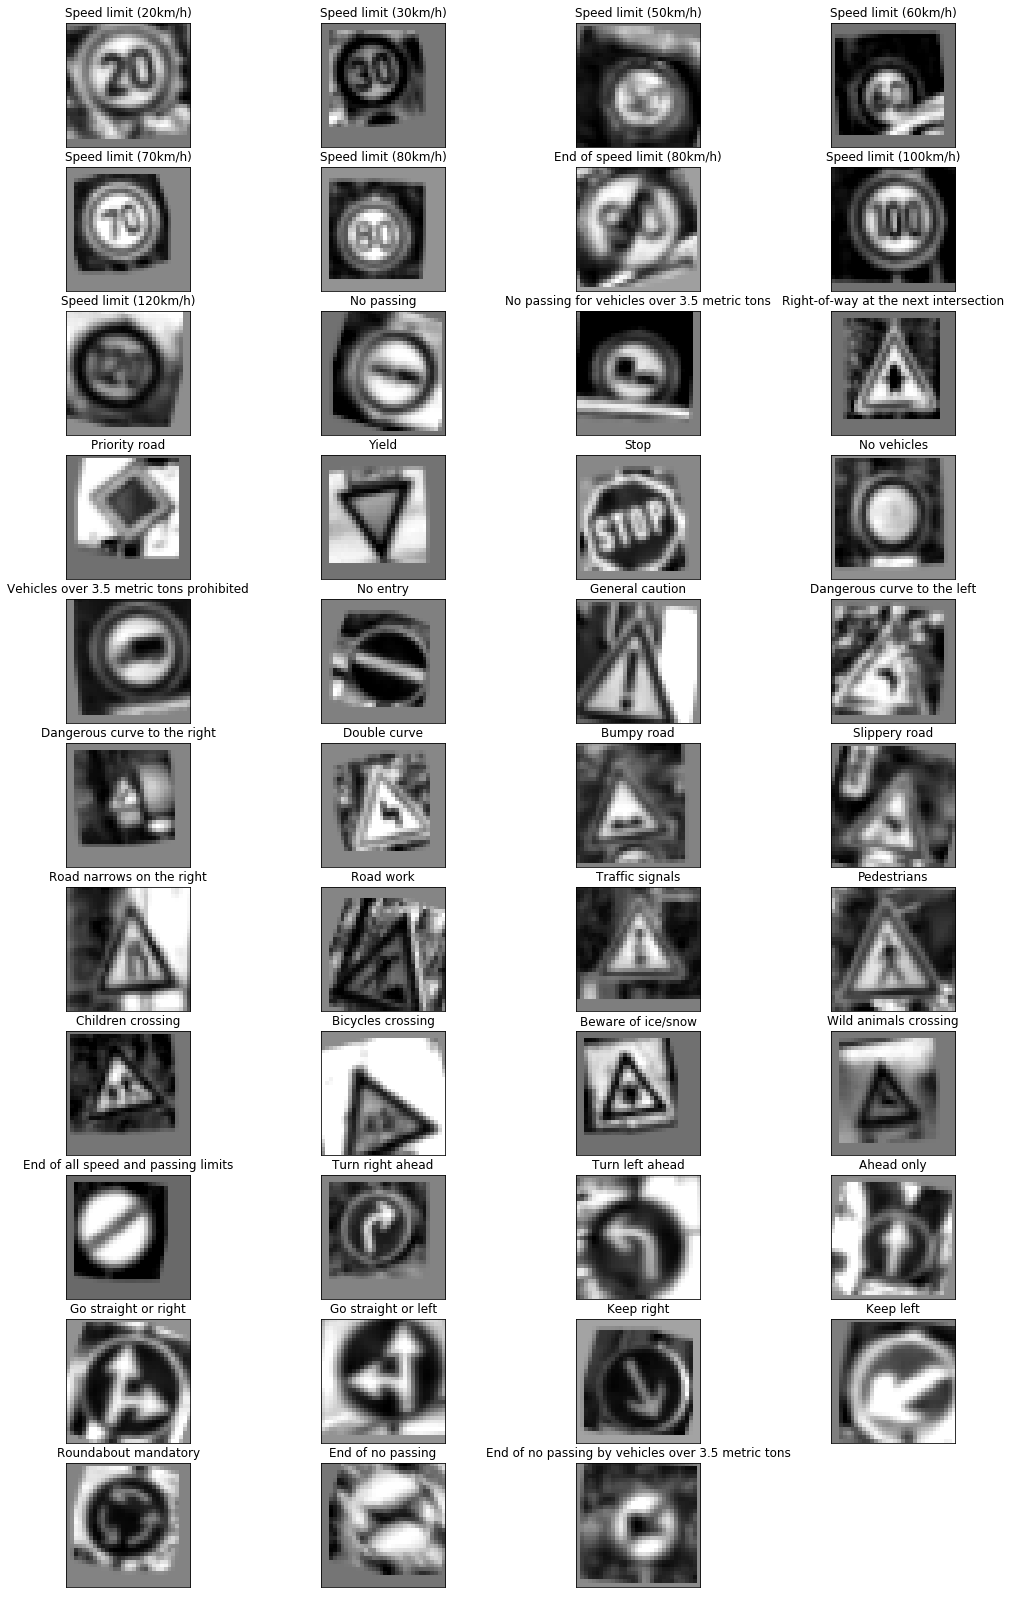

In [11]:
samples = color_normalization(samples)
samples = transform_dataset(samples)
show_images(samples, label_names, 'report_images/transformed_samples.png')

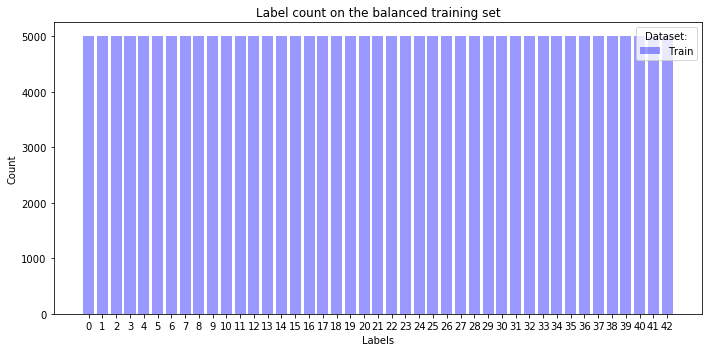

In [12]:
summarized_train = summarize_labels(y_train)

#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 5))

index = range(len(summarized_train))
rects1 = plt.bar(index, summarized_train, 0.8,
                 alpha=0.4,
                 color='b',
                 label='Train')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label count on the balanced training set')
plt.xticks(index)
plt.legend(title='Dataset:')
plt.tight_layout()
plt.show()

### Model Architecture

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='ph_x')
y = tf.placeholder(tf.int32, (None), name='ph_y')
keep_prob = tf.placeholder(tf.float32, (None), name='ph_kp')

mu = 0
sigma = 0.1

k_output = 108
color_channels = 1
filter_size =  5
weight_shape = [filter_size, filter_size, color_channels, k_output]
weight1 = tf.Variable(tf.truncated_normal(shape=weight_shape, mean = mu, stddev = sigma), name='weight_1')
bias1 = tf.Variable(tf.zeros(k_output), name='bias_1')
conv1 = tf.nn.conv2d(x, weight1, strides=[1, 1, 1, 1], padding='VALID', name='conv_1') + bias1
conv1 = tf.nn.relu(conv1, name='relu_1')
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_1')
drop1 = tf.nn.dropout(pool1, keep_prob, name='drop_1')

k_input = k_output
k_output = 200
filter_size = 5
weight_shape = [filter_size, filter_size, k_input, k_output]
weight2 = tf.Variable(tf.truncated_normal(shape=weight_shape, mean=mu, stddev=sigma), name='weight_2')
bias2 = tf.Variable(tf.zeros(k_output), name='bias_2')
conv2 = tf.nn.conv2d(drop1, weight2, strides=[1, 1, 1, 1], padding='VALID', name='conv_2') + bias2
conv2 = tf.nn.relu(conv2, name='relu_2')
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_2')
drop2 = tf.nn.dropout(pool2, keep_prob, name='drop_2')

fc1 = flatten(drop2)
fc1 = tf.layers.dense(fc1, 200, activation=tf.nn.relu, name='dense_1')
fc1 = tf.nn.dropout(fc1, keep_prob, name='drop_3')

output_layer = tf.layers.dense(fc1, 43, name='dense_2')

### Training pipeline

In [14]:
EPOCHS = 150
BATCH_SIZE = 128
RATE = 0.0001

#Training Pipeline

one_hot_y = tf.one_hot(y, 43)
logits = output_layer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

#Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

softmax = tf.nn.softmax(logits=logits)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def predict(X_data):
    sess = tf.get_default_session()
    prediction = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data, keep_prob: 1.})
    return prediction


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_train, y_train)
        testing_accuracy = evaluate(X_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.2f}%".format(training_accuracy*100))
        print("Validation Accuracy = {:.2f}%".format(validation_accuracy*100))
        
        print()
        
    saver.save(sess, './sign_classifier')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 41.24%
Validation Accuracy = 51.68%

EPOCH 2 ...
Train Accuracy = 74.54%
Validation Accuracy = 83.33%

EPOCH 3 ...
Train Accuracy = 86.57%
Validation Accuracy = 92.15%

EPOCH 4 ...
Train Accuracy = 92.06%
Validation Accuracy = 95.12%

EPOCH 5 ...
Train Accuracy = 94.97%
Validation Accuracy = 96.12%

EPOCH 6 ...
Train Accuracy = 96.62%
Validation Accuracy = 97.14%

EPOCH 7 ...
Train Accuracy = 97.50%
Validation Accuracy = 97.51%

EPOCH 8 ...
Train Accuracy = 98.17%
Validation Accuracy = 97.66%

EPOCH 9 ...
Train Accuracy = 98.61%
Validation Accuracy = 97.73%

EPOCH 10 ...
Train Accuracy = 98.93%
Validation Accuracy = 98.10%

EPOCH 11 ...
Train Accuracy = 99.13%
Validation Accuracy = 98.21%

EPOCH 12 ...
Train Accuracy = 99.25%
Validation Accuracy = 98.12%

EPOCH 13 ...
Train Accuracy = 99.43%
Validation Accuracy = 98.23%

EPOCH 14 ...
Train Accuracy = 99.49%
Validation Accuracy = 98.32%

EPOCH 15 ...
Train Accuracy = 99.59%
Validation Accuracy =

EPOCH 122 ...
Train Accuracy = 100.00%
Validation Accuracy = 98.89%

EPOCH 123 ...
Train Accuracy = 100.00%
Validation Accuracy = 98.91%

EPOCH 124 ...
Train Accuracy = 100.00%
Validation Accuracy = 98.93%

EPOCH 125 ...
Train Accuracy = 100.00%
Validation Accuracy = 99.00%

EPOCH 126 ...
Train Accuracy = 100.00%
Validation Accuracy = 99.00%

EPOCH 127 ...
Train Accuracy = 100.00%
Validation Accuracy = 99.02%

EPOCH 128 ...
Train Accuracy = 100.00%
Validation Accuracy = 99.07%

EPOCH 129 ...
Train Accuracy = 100.00%
Validation Accuracy = 99.02%

EPOCH 130 ...
Train Accuracy = 100.00%
Validation Accuracy = 99.00%

EPOCH 131 ...
Train Accuracy = 100.00%
Validation Accuracy = 98.96%

EPOCH 132 ...
Train Accuracy = 100.00%
Validation Accuracy = 99.00%

EPOCH 133 ...
Train Accuracy = 100.00%
Validation Accuracy = 99.05%

EPOCH 134 ...
Train Accuracy = 100.00%
Validation Accuracy = 98.93%

EPOCH 135 ...
Train Accuracy = 100.00%
Validation Accuracy = 98.98%

EPOCH 136 ...
Train Accuracy = 100

In [16]:
#Evaluate the Model (Test)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.2f}%".format(test_accuracy*100))
    

INFO:tensorflow:Restoring parameters from ./sign_classifier
Test Accuracy = 98.88%


---
Let's take a look on the misses from the validation set:

INFO:tensorflow:Restoring parameters from ./sign_classifier


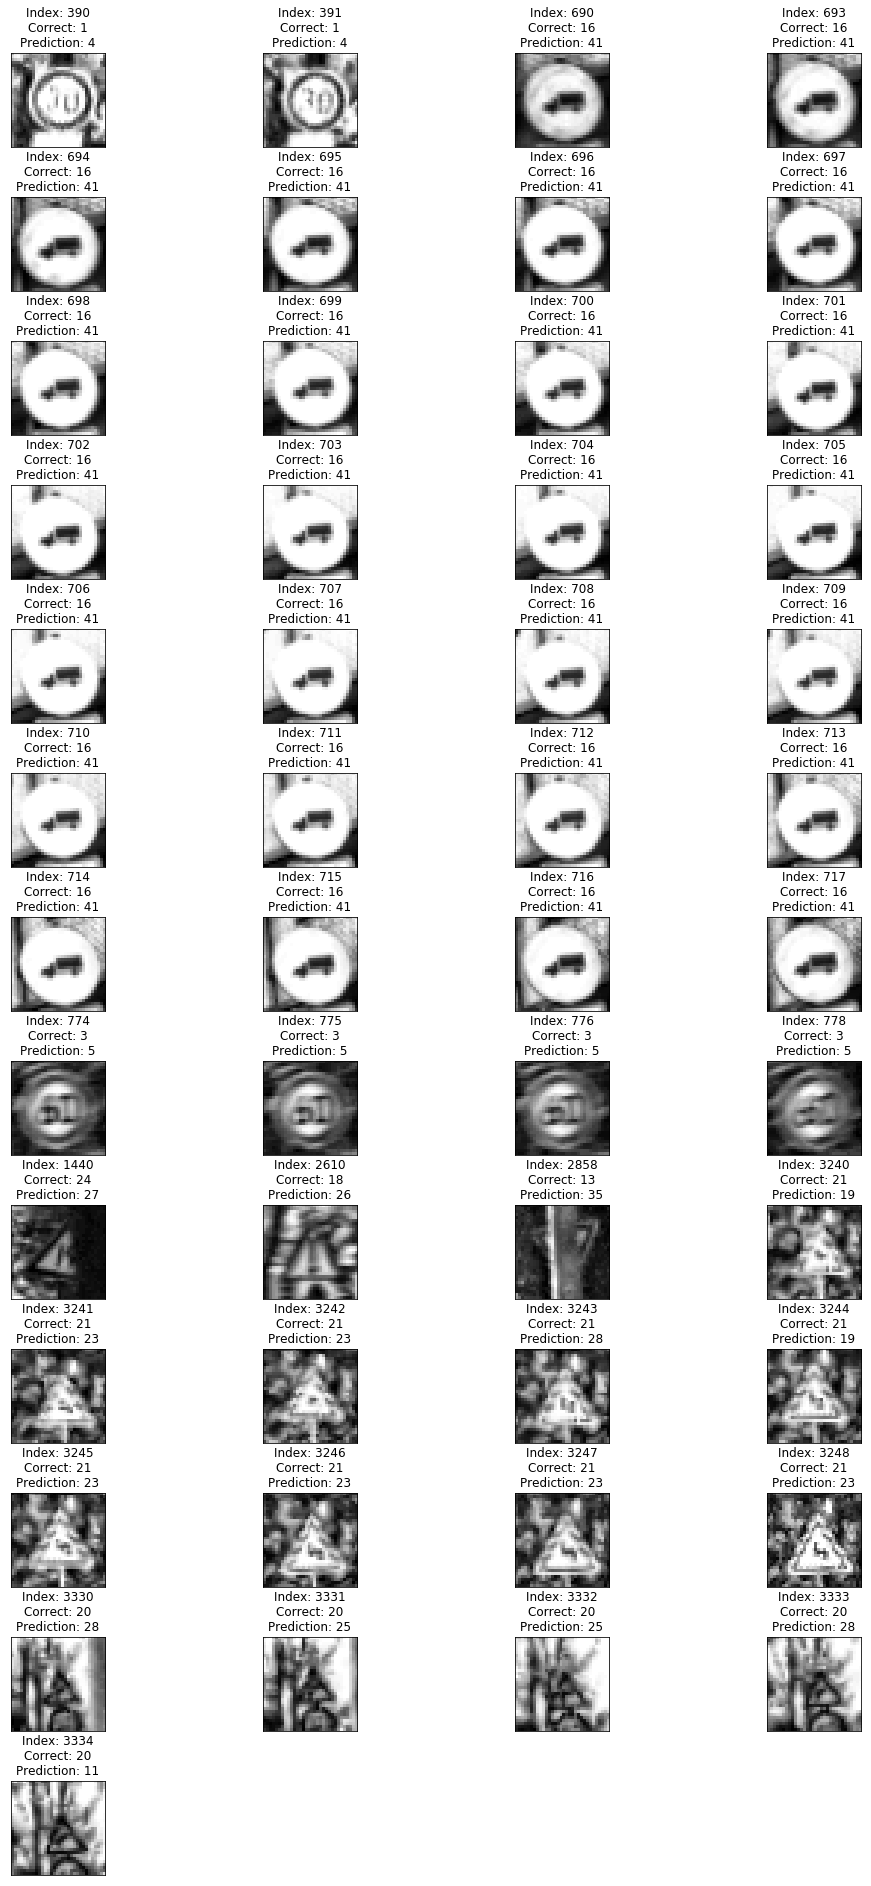

In [17]:
#Visualize the misses on the validation set
def misses(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    miss = []
    sess = tf.get_default_session()
    for i, X in enumerate(X_data):
        correct = sess.run(correct_prediction, feed_dict={x: [X], y: [y_data[i]], keep_prob: 1.})
        if not correct:
            prediction = sess.run(tf.argmax(logits, 1), feed_dict={x: [X], y: [y_data[i]], keep_prob: 1.})
            miss.append((X, prediction[0], y_data[i], i))
    return miss

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.')) 
    miss = misses(X_valid, y_valid)
    
X_miss = np.reshape([x[0] for x in miss], (len(miss), 32, 32))
titles = ['Index: {}\nCorrect: {}\nPrediction: {}'.format(x[3], x[2], x[1]) for x in miss]
show_images(X_miss, titles)  

As shown here, most of the misses are over saturated, or have too much noise, or are some how obstructed.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

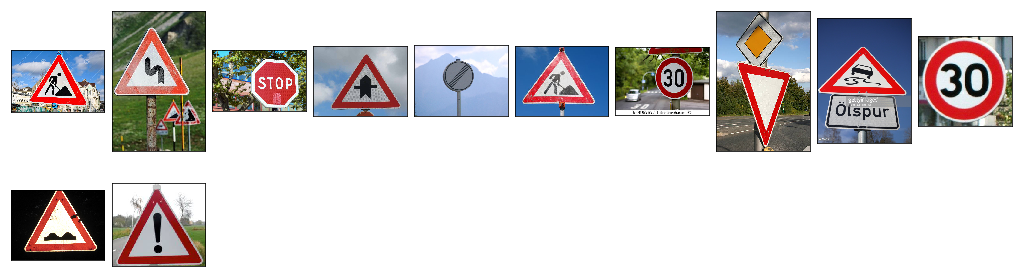

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

image_files = os.listdir("google_images/")
images = []
for file in image_files:
    images.append(mpimg.imread('google_images/{}'.format(file)))
show_images(images, path='report_images/google_images.png')


The images above were croped and resized to 32x32 pixels

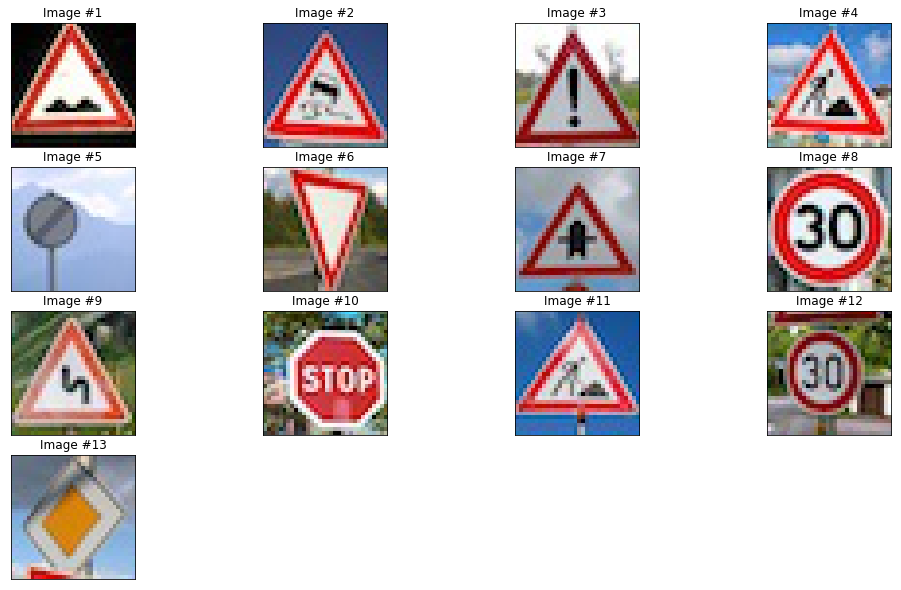

In [19]:
image_files = os.listdir("google_images_32x32_jpg/")
images = []
for file in image_files:
    images.append(mpimg.imread('google_images_32x32_jpg/{}'.format(file)))
titles = ['Image #{}'.format(x+1) for x in range(0, len(images))]   
show_images(images, titles, path='report_images/google_images_32x32.png')

Preprocessing those images

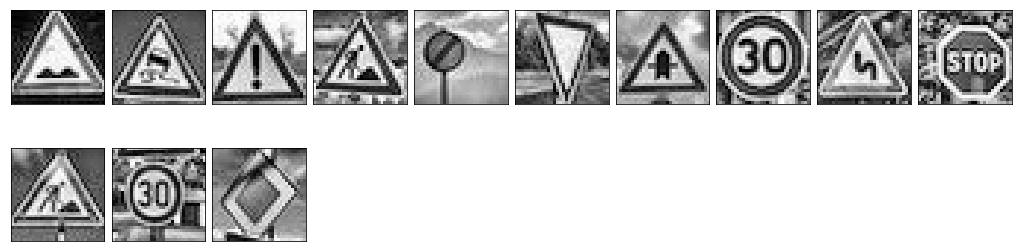

In [20]:
images_gray = color_normalization(images)
show_images(images_gray, path='report_images/tranformed_google.png')

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./sign_classifier
[22 23 18 25 32 13 11  1 21 14 25  1 12]


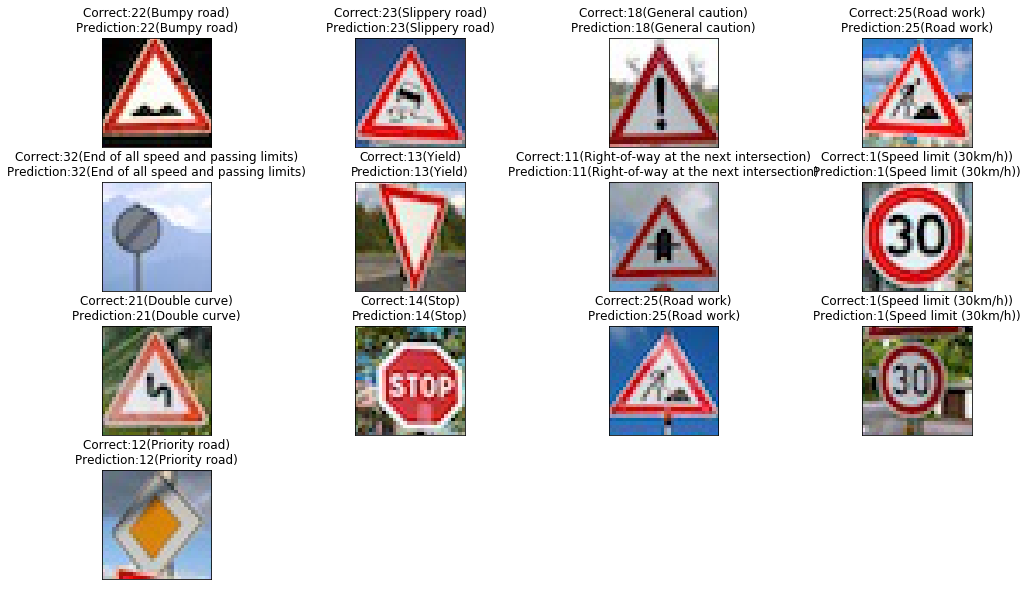

In [21]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

ys=[22, 23, 18, 25, 32, 13, 11, 1, 21, 14, 25, 1, 12]
images_gray = np.reshape(images_gray, (len(images_gray), 32, 32, 1))
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction = predict(images_gray)
    print(prediction)
    
titles = ['Correct:{}({})\nPrediction:{}({})'.format(y, label_names[y], x, label_names[x]) for x,y in zip(prediction, ys)]
#images = np.reshape(images, (len(images), 32, 32))
show_images(images, titles, 'report_images/predictions.png')
    

### Analyze Performance

In [22]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(images_gray, ys)
    print("Test Accuracy = {:.2f}%".format(test_accuracy*100))
    

INFO:tensorflow:Restoring parameters from ./sign_classifier
Test Accuracy = 100.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [23]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits=logits), 5), feed_dict={x: images_gray, keep_prob: 1.})
    #prediction = sess.run(tf.argmax(logits, 1), feed_dict={x: X_valid, keep_prob: 1.})
    print(top_k)

INFO:tensorflow:Restoring parameters from ./sign_classifier
TopKV2(values=array([[  1.00000000e+00,   3.55820495e-12,   2.08267605e-12,
          1.52321331e-15,   6.60976618e-18],
       [  1.00000000e+00,   1.28481081e-09,   2.52276851e-13,
          6.53797336e-17,   7.50966879e-19],
       [  1.00000000e+00,   1.59188683e-15,   8.68387111e-17,
          8.03401807e-19,   9.02613281e-20],
       [  1.00000000e+00,   6.04516403e-16,   4.19823886e-16,
          2.58224056e-16,   1.72778302e-18],
       [  4.86856192e-01,   3.55789065e-01,   1.12067141e-01,
          2.55951211e-02,   1.21963574e-02],
       [  1.00000000e+00,   2.19438695e-25,   8.06469513e-26,
          6.07570712e-30,   8.87134584e-31],
       [  1.00000000e+00,   3.09800341e-12,   2.95058405e-14,
          2.28840825e-14,   4.70191462e-15],
       [  1.00000000e+00,   9.85823531e-15,   5.14037953e-15,
          2.12640485e-15,   1.67207406e-15],
       [  1.00000000e+00,   1.33061770e-10,   6.85473553e-12,
        

In [24]:
for i in range(len(top_k[0])):
    print('Image #{} ({}):'.format(i, label_names[ys[i]]))
    for j in range(len(top_k[0][i])):
        print('\t{:.2f}% chance of {}'.format(top_k[0][i][j]*100, label_names[top_k[1][i][j]]))

Image #0 (Bumpy road):
	100.00% chance of Bumpy road
	0.00% chance of Slippery road
	0.00% chance of Bicycles crossing
	0.00% chance of Road work
	0.00% chance of Traffic signals
Image #1 (Slippery road):
	100.00% chance of Slippery road
	0.00% chance of Bicycles crossing
	0.00% chance of Beware of ice/snow
	0.00% chance of Wild animals crossing
	0.00% chance of Double curve
Image #2 (General caution):
	100.00% chance of General caution
	0.00% chance of Traffic signals
	0.00% chance of Pedestrians
	0.00% chance of Road narrows on the right
	0.00% chance of Right-of-way at the next intersection
Image #3 (Road work):
	100.00% chance of Road work
	0.00% chance of Bumpy road
	0.00% chance of Dangerous curve to the right
	0.00% chance of Beware of ice/snow
	0.00% chance of Slippery road
Image #4 (End of all speed and passing limits):
	48.69% chance of End of all speed and passing limits
	35.58% chance of Traffic signals
	11.21% chance of General caution
	2.56% chance of Bicycles crossing
	1

From the top k above, we get the probabilities for each image as follows

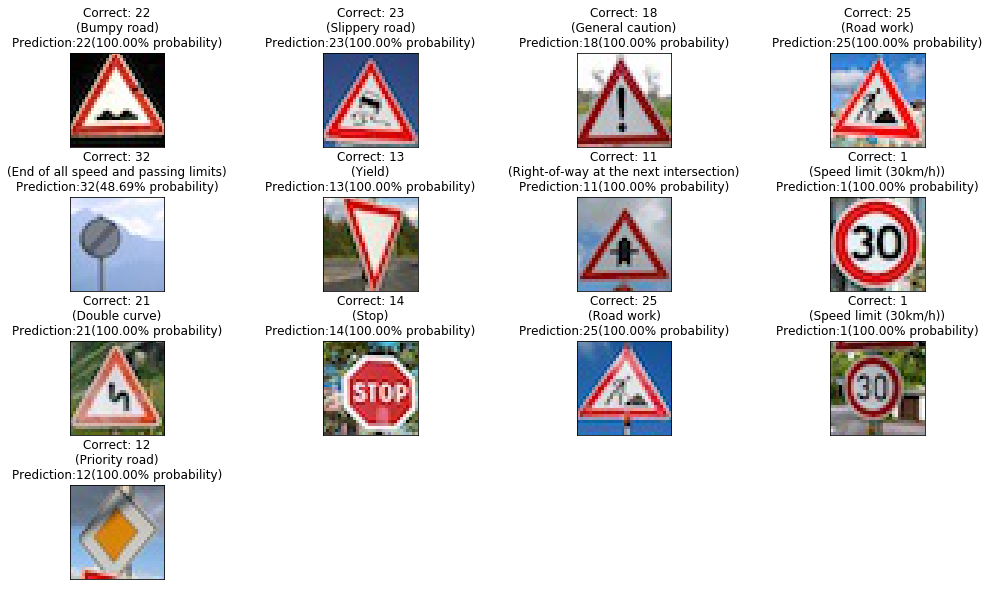

In [25]:
titles = []
for i in range(len(images_gray)):
    y_hat = top_k[1][i][0]
    p = top_k[0][i][0]
    y = ys[i]
    label = label_names[y]
    title = 'Correct: {}\n({})\nPrediction:{}({:.2f}% probability)'.format(y, label, y_hat, p*100)
    titles.append(title)

    #images = np.reshape(images, (len(images), 32, 32))    
show_images(images, titles, path='report_images/probability.png')

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [26]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
def show_featuremaps(images):  
    cols = 10
    rows = (len(images) - 1)//cols + 1
    plt.figure(figsize=(14, 2*rows))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1, path=None):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    sess = tf.get_default_session()
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1.})
    featuremaps = activation.shape[3]
    cols = 10
    rows = (featuremaps - 1)//cols + 1
    
    plt.figure(plt_num, figsize=(20,2*rows))
    for featuremap in range(featuremaps):
        plt.subplot(rows,cols, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.tight_layout(pad=0, h_pad=1, w_pad=0)
    if path:
        plt.savefig(path, format='png')
    plt.show()         


Feature maps for the first convolutional layer for a correctly classified image:

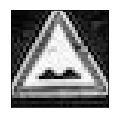

In [27]:
show_images(np.reshape([images_gray[0]],(1, 32, 32)), path='report_images/hit.png')

INFO:tensorflow:Restoring parameters from ./sign_classifier


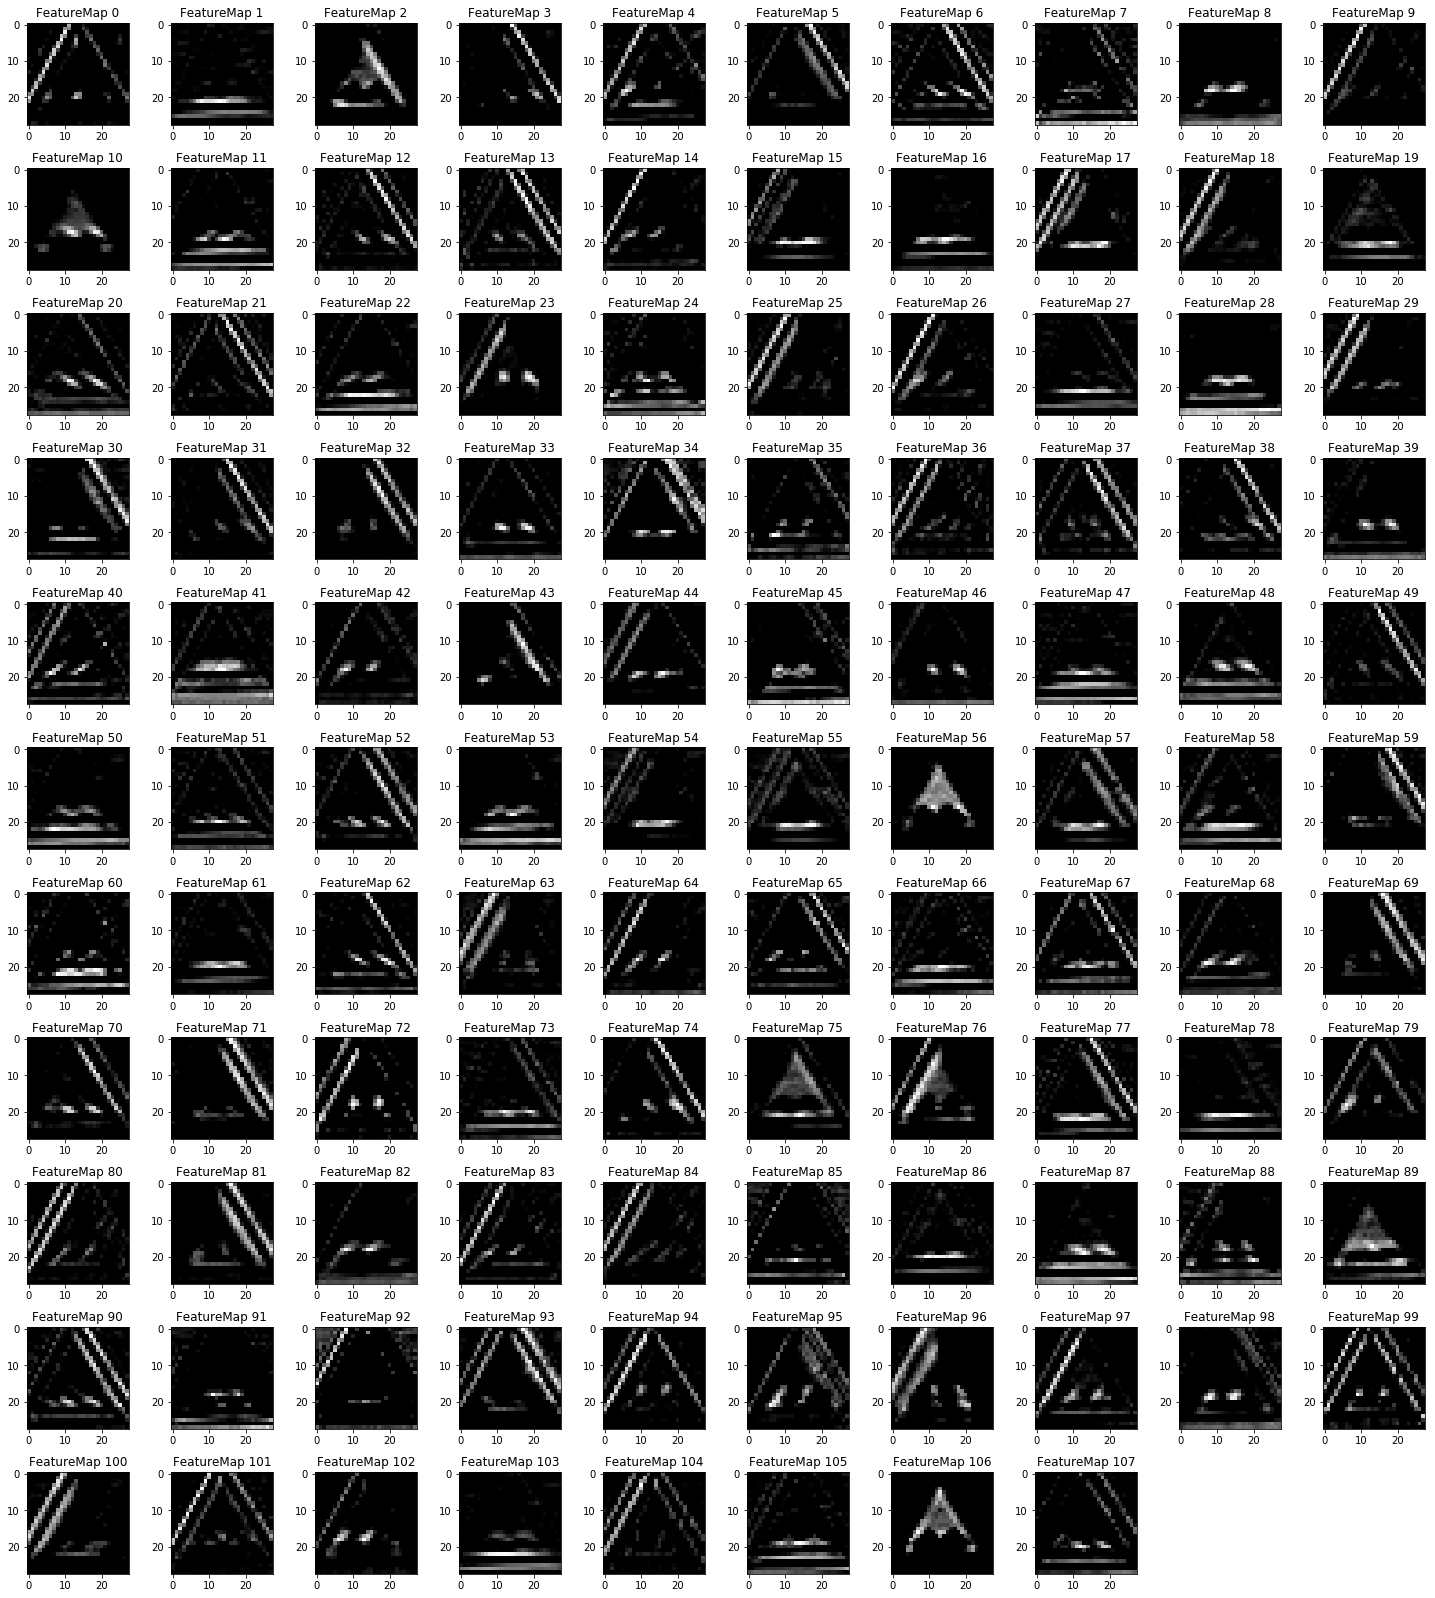

In [28]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))         
    outputFeatureMap([images_gray[0]], conv1, 0, path='report_images/conv1_hit.png') 

Feature maps for the second convolutional layer

INFO:tensorflow:Restoring parameters from ./sign_classifier


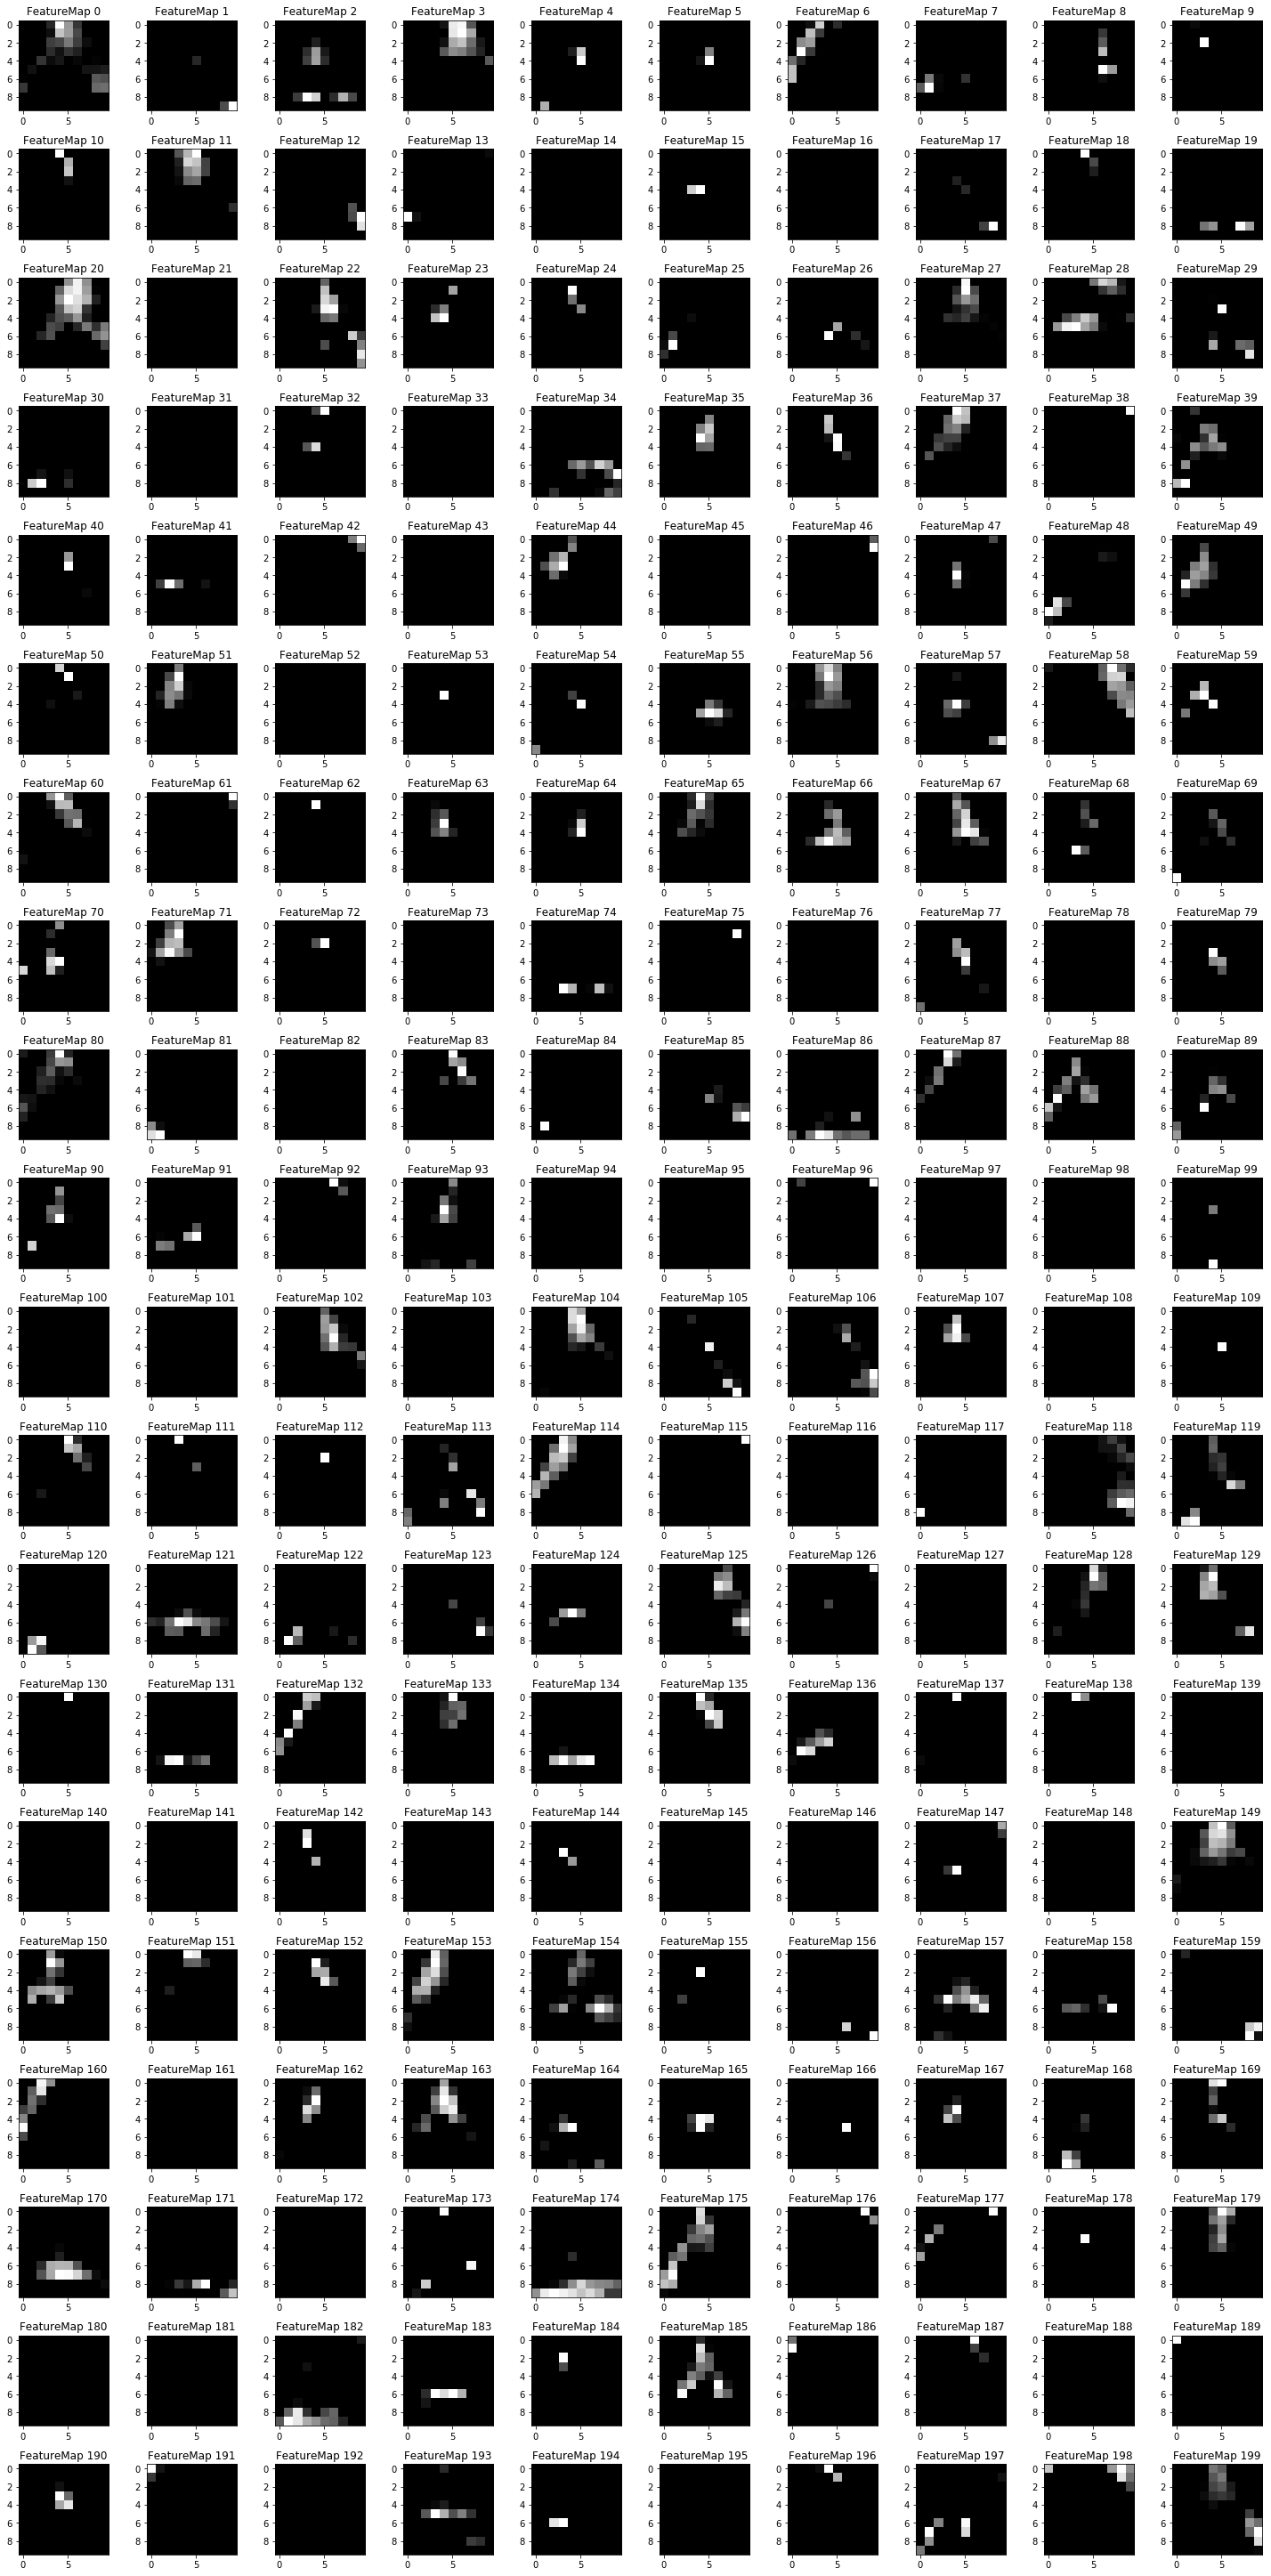

In [29]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))         
    outputFeatureMap([images_gray[0]], conv2, 0, path='report_images/conv2_hit.png') 

Feature maps for the first convolutional layer for an incorrectly classified image:

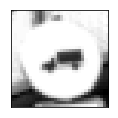

In [30]:
show_images(np.reshape([X_valid[707]],(1, 32, 32)), path='report_images/miss.png')

INFO:tensorflow:Restoring parameters from ./sign_classifier


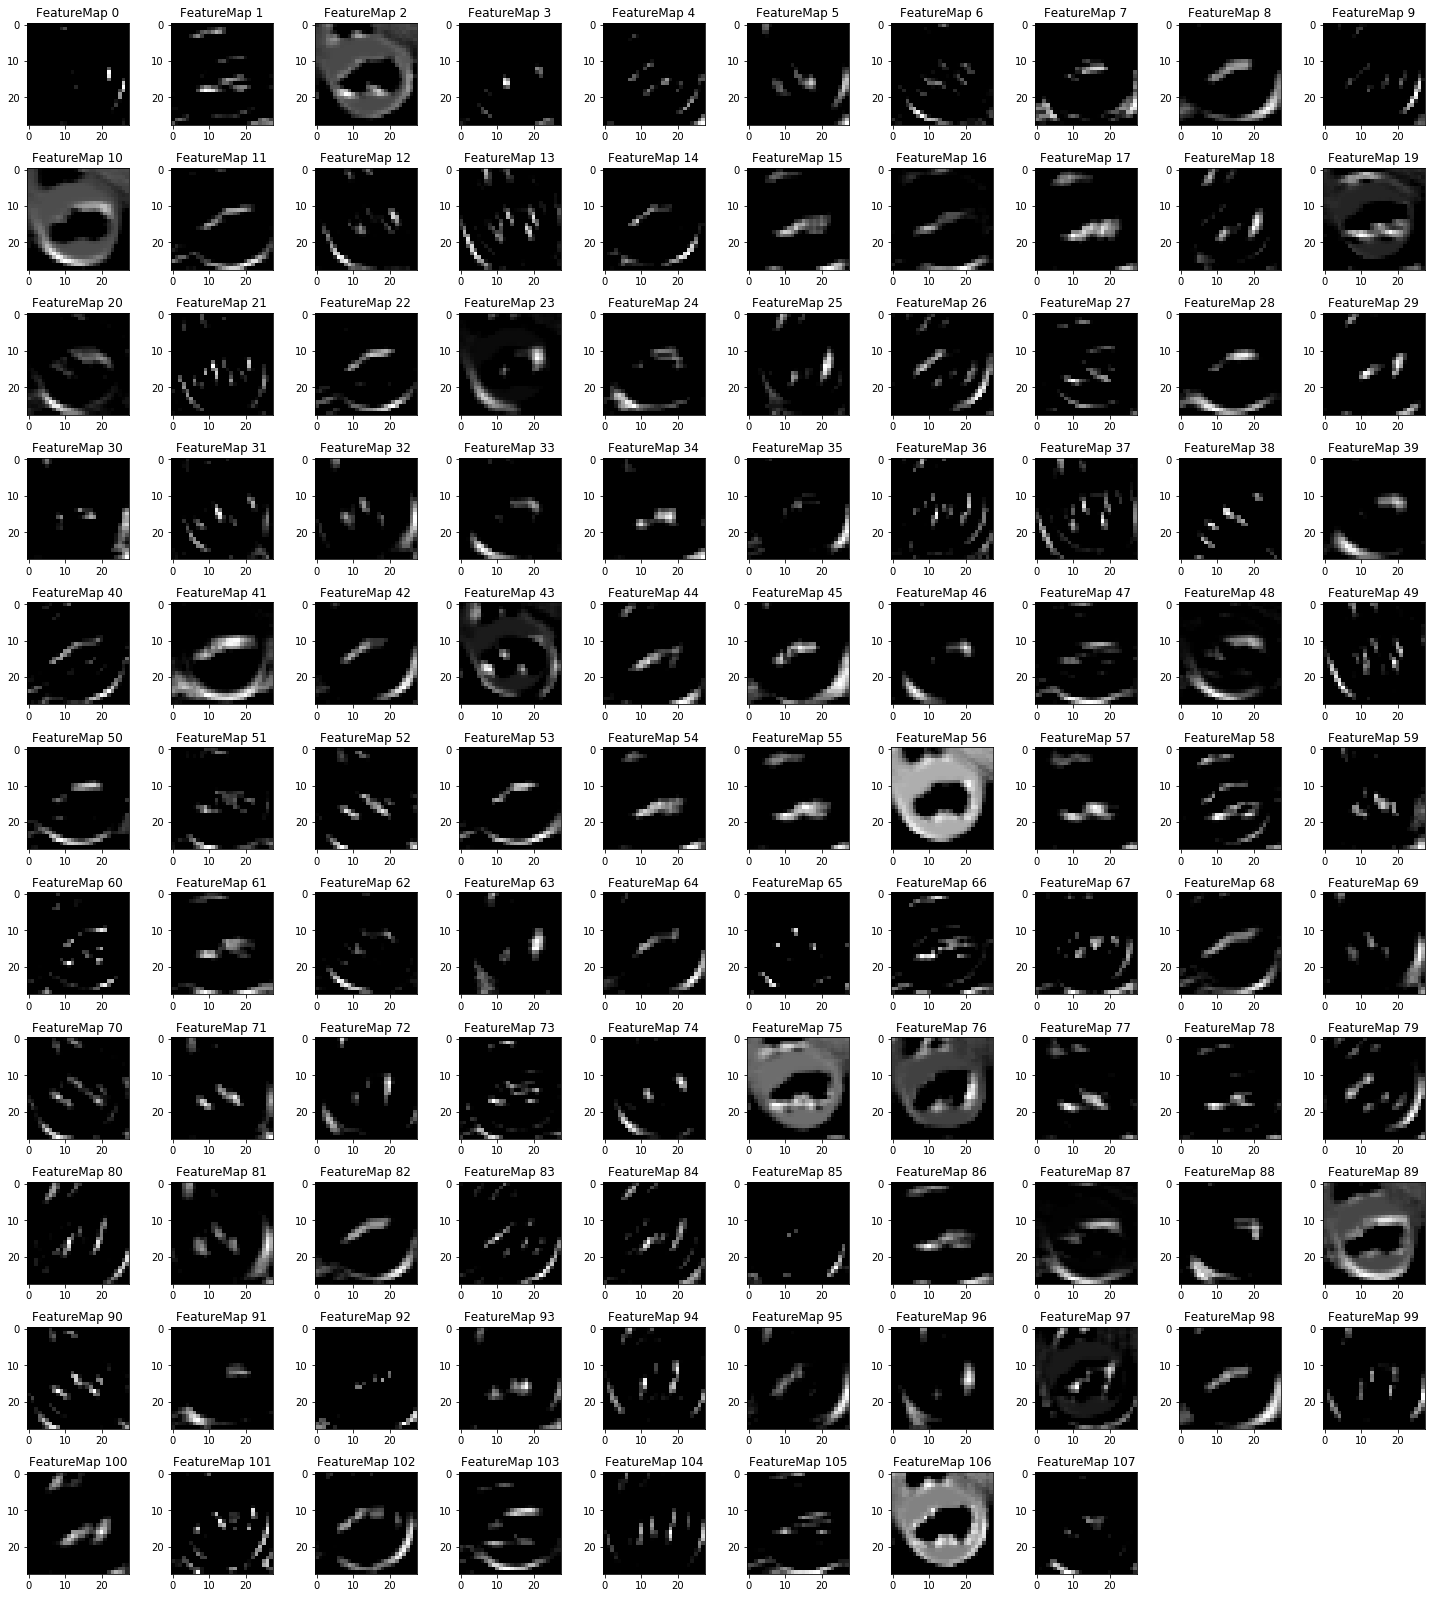

In [31]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))         
    outputFeatureMap([X_valid[707]], conv1, 0, path='report_images/conv1_miss.png') 

Feature maps for the second convolutional layer

INFO:tensorflow:Restoring parameters from ./sign_classifier


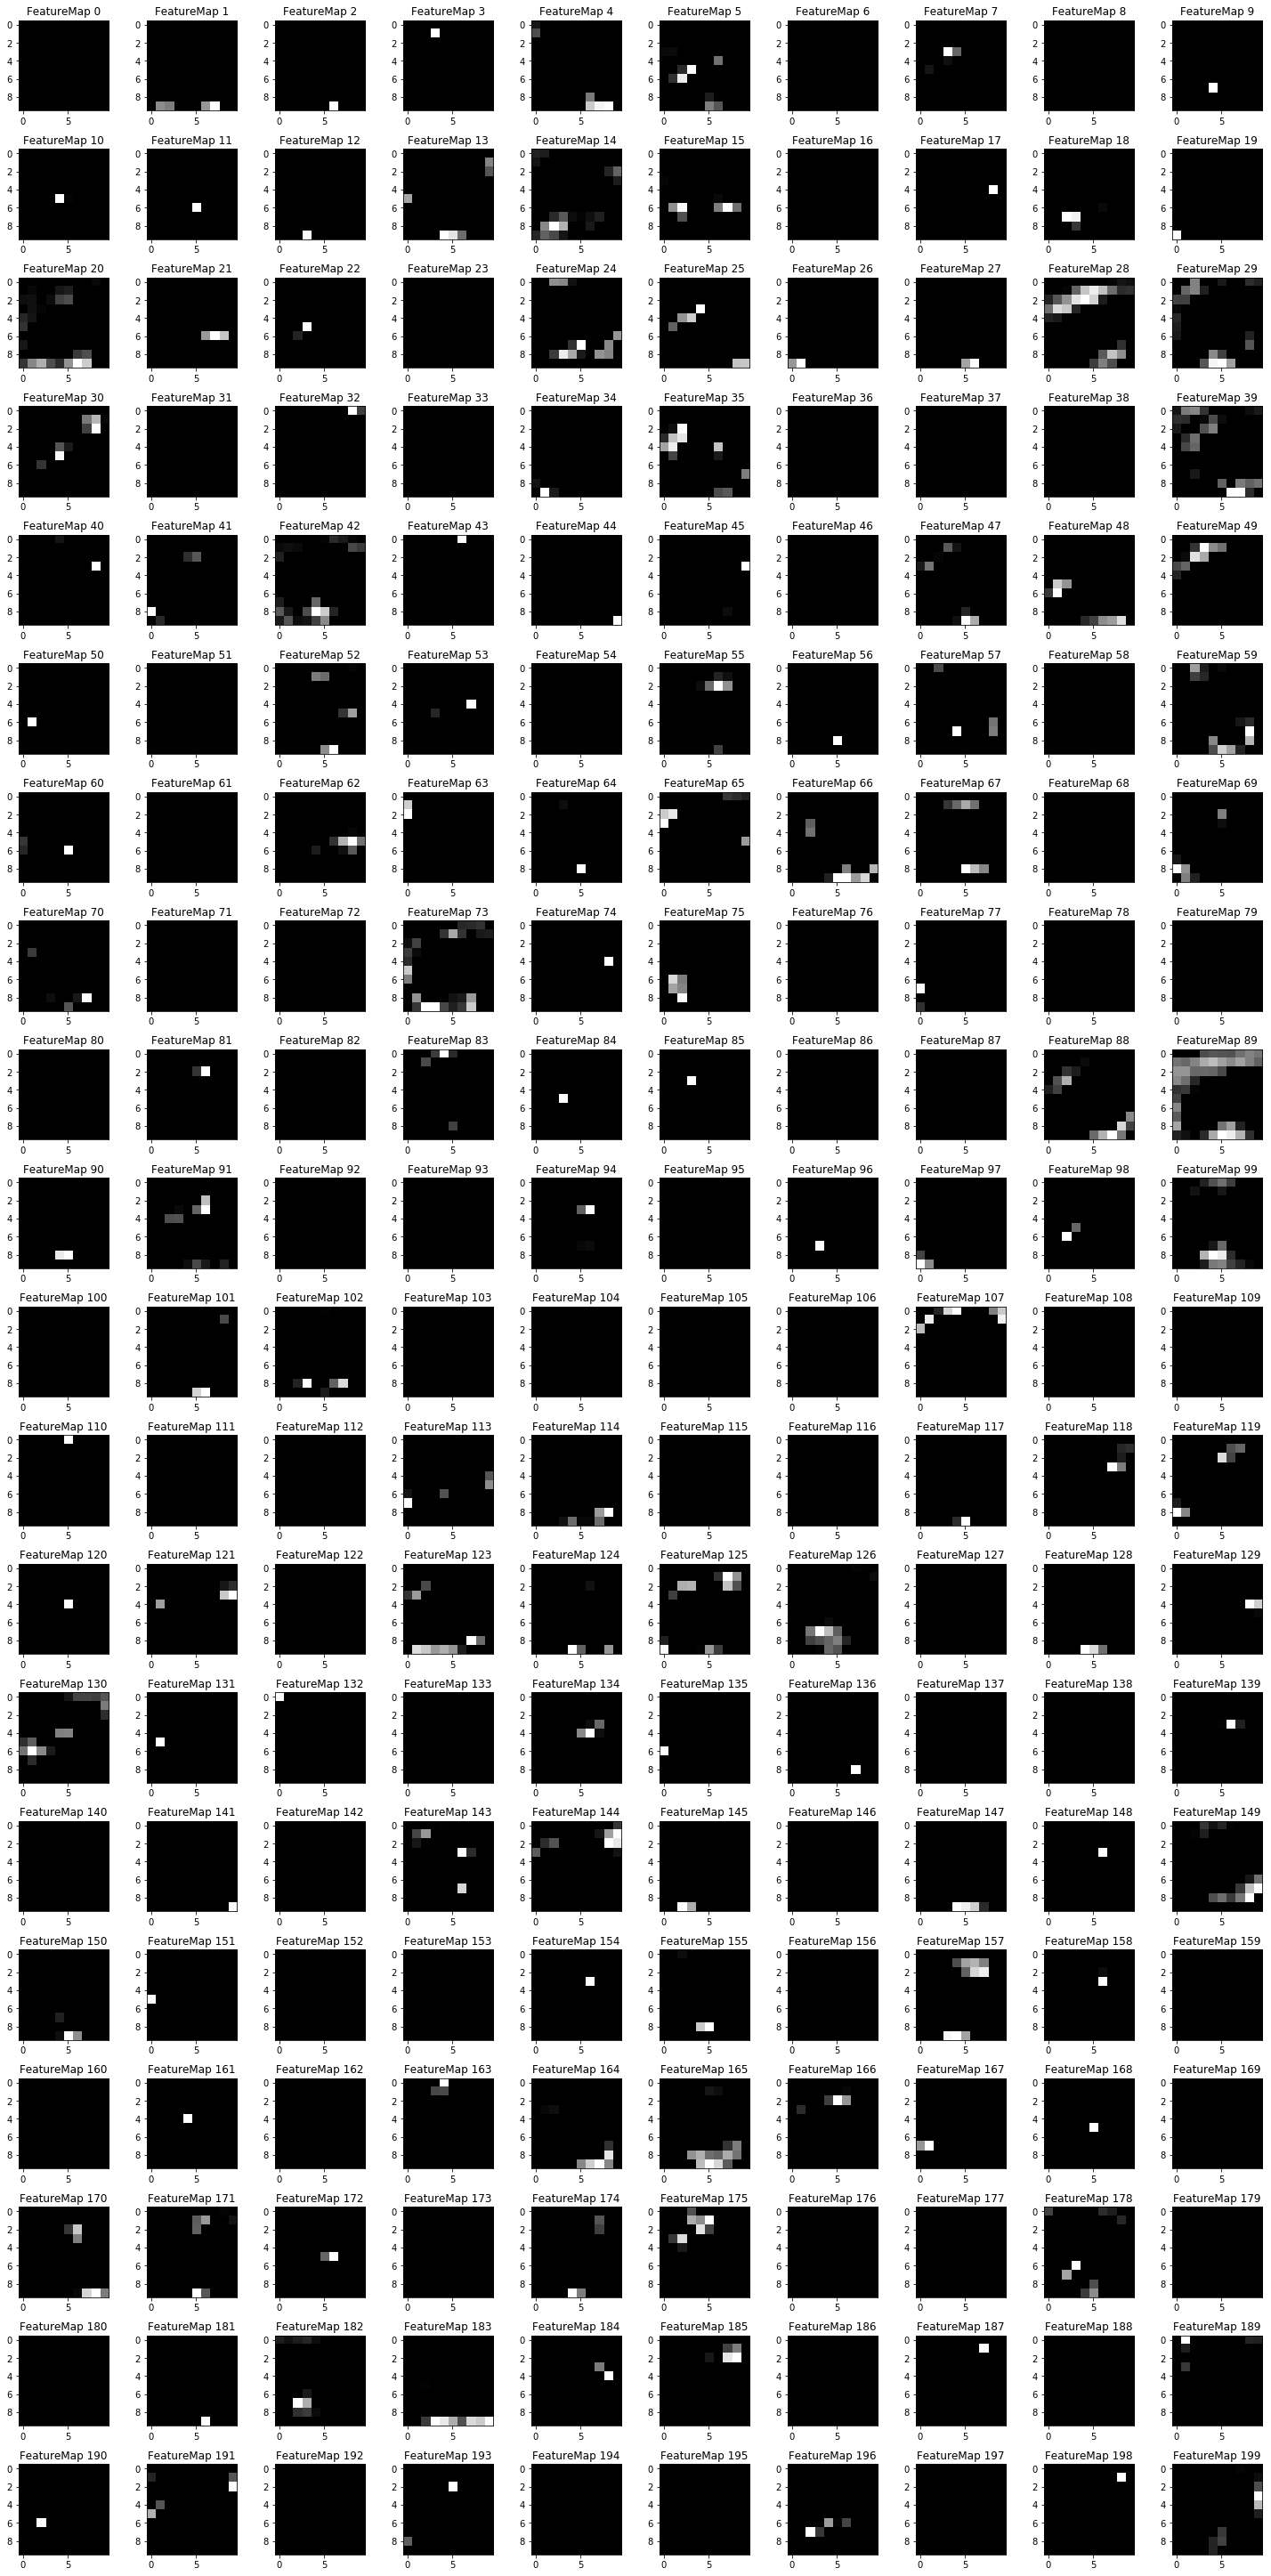

In [32]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))         
    outputFeatureMap([X_valid[707]], conv2, 0, path='report_images/conv2_miss.png') 

For the correctly classified image, it is possible to identify some recognizable features on the first convolutional layer's feature maps, the sign's boundary outline can be seen in almost all feature maps, and the inner symbol of the sign is also marked in most of the filters, whilst for the misclassified image it is quite hard to identify any meaningful feature, the sign's symbol can be some how indentified in only a few feature maps.

For the second convolutional layer feature maps, I couldn't visualize any useful information for my human eyes on both images.
